<a href="https://colab.research.google.com/github/cherylktt/2020-Invent/blob/master/09_milestone_project_2_skimlit_with_model_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts earlier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

Reading through the paper above, we see that the model architecure that they usee to achieve their best results is available here: https://arxiv.org/abs/1612.05251

If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb).

## Confirm access to a GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a26827fa-745f-a460-d887-cf9655e0287f)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used. We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


## Using 10% of the data

In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by the "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the files in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess data

Now that we've got some text data, it's time to become with it. One of the best ways to become one with the data is to visualise it. So with that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename (str): contains the target filepath
  
  Returns:
    A list of strings with one string per line form the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Let's think about how we want our data to look.

How our data would be best represented:

```
[{'line_numer': 0,
   'target_label': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
 ...
]
```


Let's write a function which turns each of our datasets into the above format.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target lable, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
      
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower()  # get text and lower it
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line_data to abstract_samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 410 ms, sys: 86 ms, total: 496 ms
Wall time: 488 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualise it?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(14)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

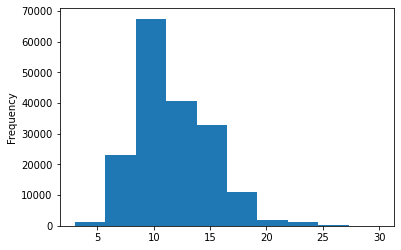

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

#### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 14 lines of training sentences
train_sentences[:14]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # sparse matrix is incomptible with tensors
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what the labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Modelling Experiments

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

* `model_0`: Naive Bayes with TF-IDF encoder (baseline)
* `model_1`: Conv1D with token embeddings
* `model_2`: TensorFlow Hub Pretrained Feature Extractor
* `model_3`: Conv1D with character embeddings
* `model_4`: Pretrained token embeddings (same as 2) + character embeddings (same as 3)
* `model_5`: Pretrained token embeddings + character embeddings + positional embeddings

And as always, we're going to start with a baseline.

### Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy score of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy score of: 72.18%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
val_labels_encoded[:20]

array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1, 0, 0, 0, 3, 2, 2, 4, 4, 4, 4])

#### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather than rewriting it here, let's download it from the helper function script.

In [ ]:
!wget https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py

--2022-05-15 07:18:36--  https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16898 (17K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  16.50K  --.-KB/s    in 0.002s  

2022-05-15 07:18:36 (8.99 MB/s) - ‘helper_functions.py’ saved [16898/16898]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate basline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

### Preparing our data for deep sequence models

Before we start building deep models, we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Find the average number of tokens in the training sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

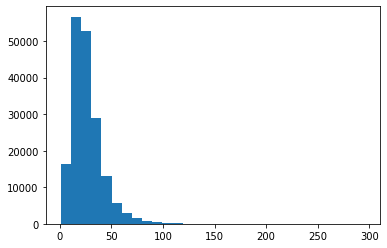

In [ ]:
# Check the distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

#### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
from tensorflow.keras.layers import TextVectorization

# Set up text vectorization variables
max_tokens = 68000 # based on table 2 in https://arxiv.org/abs/1710.06071

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len,
                                    name="vectorizer")

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on some random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Sentence:\n{target_sentence}\n")
print(f"Length of sentence: {len(target_sentence.split())}\n")
print(f"Vectorized sentence:\n{text_vectorizer([target_sentence])}\n")

Sentence:
no significant difference was observed in the response to treatment among these groups .

Length of sentence: 14

Vectorized sentence:
[[ 33  37  74  10 148   5   2 142   6  19 116 111  24   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]



In [ ]:
# How many words are there in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in the vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in the vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'vectorizer',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

#### Create custom text embedding

In [ ]:
embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero = True, # use masking to handle variable sequence lengths (save space)
                             name="token_embedding",
                             input_length=output_seq_len)

In [ ]:
# View embedding on random sentences
print(f"Sentence:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Vectorized sentence before embedding:\n{vectorized_sentence}\n")
embedded_sentence = embedding(vectorized_sentence)
print(f"Embedded sentence:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence:
through pill count , @ % of participants were adherent at @ month and @ % at @ year .

Vectorized sentence before embedding:
[[ 313 4105  994    4   60    9 6568   15  178    3   15  157    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedded sentence:
[[[ 0.01355157  0.0237193   0.02460786 ... -0.00246284 -0.02153822
   -0.01885553]
  [-0.01286914 -0.02889316 -0.01825424 ... -0.03501674 -0.00865474
    0.03230846]
  [-0.02606072  0.03723793  0.03050593 ... -0.04948592 -0.0278221
    0.01900214]
  ...
  [ 0.04625544  0.03355685  0.02274277 ...  0.04086233 -0.03544289
   -0.0137776 ]
  [ 0.04625544  0.03355685  0.02274277 ...  0.04086233 -0.03544289
   -0.0137776 ]
  [ 0.04625544  0.03355685  0.02274277 ...  0.04086233 -0.03544289
   -0.0137776 ]]]

Embedded sentence shape: (1, 55, 128)


### Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow `tf.data API`. Many of the steps here are discussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D model with token embeddings

In [ ]:
from tensorflow.keras import layers
model_1_vectorizer = TextVectorization(max_tokens=max_tokens,
                                       output_sequence_length=output_seq_len,
                                       name="vectorizer_1")
model_1_vectorizer.adapt(train_sentences)
model_1_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                     output_dim=128,
                                     mask_zero = True,
                                     input_length=output_seq_len,
                                     name="embedding_1")

# Build a Conv1D model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectorizer = model_1_vectorizer(inputs)
embedding_layer = model_1_embedding(text_vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(embedding_layer)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_Conv1D_with_token_embeddings")

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a model summary
model_1.summary()

Model: "model_1_Conv1D_with_token_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 vectorizer_1 (TextVectoriza  (None, 55)               0         
 tion)                                                           
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 18s 9ms/step - loss: 0.9193 - accuracy: 0.6378 - val_loss: 0.6907 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6587 - accuracy: 0.7575 - val_loss: 0.6301 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6192 - accuracy: 0.7744 - val_loss: 0.5979 - val_accuracy: 0.7806


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5980 - accuracy: 0.7850


[0.5979945659637451, 0.7849860787391663]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.0842471e-01, 1.9687417e-01, 7.0966646e-02, 2.9305661e-01,
         3.0677866e-02],
        [4.1318589e-01, 3.0950168e-01, 1.0435772e-02, 2.5766513e-01,
         9.2114788e-03],
        [1.2080232e-01, 6.4628441e-03, 2.0366365e-03, 8.7062848e-01,
         6.9709073e-05],
        ...,
        [4.0892869e-06, 6.5716315e-04, 8.3892007e-04, 2.8486577e-06,
         9.9849701e-01],
        [4.9439162e-02, 4.5401126e-01, 9.0991646e-02, 6.0650248e-02,
         3.4490779e-01],
        [2.1575102e-01, 6.3960588e-01, 5.3214006e-02, 4.0568985e-02,
         5.0860163e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.49860982391102,
 'f1': 0.7822449426770718,
 'precision': 0.7814432866923935,
 'recall': 0.7849860982391103}

### Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub, more specifically the [universal sentence encoder](https://tfhub.dev/google/universal-sentence-encoder/4).

The paper originally used GloVe embeddings, however we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
import random
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Embedded sentence:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
the level of significance was set at @ % .

Embedded sentence:
[-0.01233169 -0.01980469 -0.06462684 -0.0019372  -0.00885767 -0.06752824
 -0.09917533 -0.04065282  0.0650756   0.00581818 -0.04697759  0.05729908
 -0.05818127 -0.00915236 -0.00523962  0.01776898  0.03362289 -0.00142535
  0.07577954 -0.01985724 -0.05276547  0.06028687  0.06671301  0.05366863
 -0.00990894  0.06071399  0.06821565  0.01587476  0.04395925  0.04370228]

Length of sentence embedding: 512


#### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=val_dataset,
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9150 - accuracy: 0.6489 - val_loss: 0.7937 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7656 - accuracy: 0.7022 - val_loss: 0.7515 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7483 - accuracy: 0.7141 - val_loss: 0.7346 - val_accuracy: 0.7181


In [ ]:
# Evalute the model
model_2.evaluate(val_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7381 - accuracy: 0.7158


[0.738060712814331, 0.7158082723617554]

In [ ]:
# Make predictions and calculate results
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.58082880974447,
 'f1': 0.7128306943656024,
 'precision': 0.7165876729594589,
 'recall': 0.7158082880974447}

> `model_2` performed way worse than `model_1` and around the same as `model_0` (baseline model)

### Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously, we've used token-level embeddings, but we'll need to do similar steps for characters if we want to use char-level embeddings.

#### Creating a character-level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character level sequence into characters
split_chars(random_train_sentence)

't h e   l e v e l   o f   s i g n i f i c a n c e   w a s   s e t   a t   @   %   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
import numpy as np
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

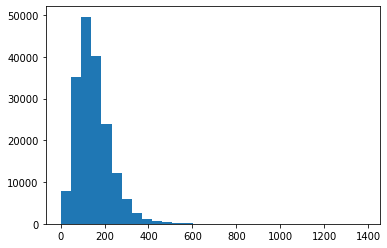

In [ ]:
# Check the distribution of our sequences at a character level
import matplotlib.pyplot as plt
plt.hist(char_len, bins=30);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and 00V token (out of vocab '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    #standardize=None, # for if you want to leave punctuation in
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}\n")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
w e   t e s t e d   t h e   h y p o t h e s i s   t h a t   t h e   i n c i d e n c e   o f   t h e   r e c u r r e n c e   o f   a n   i n f a r c t   w o u l d   b e   l o w e r   a m o n g   c h i l d r e n   w h o   u n d e r w e n t   r e g u l a r   b l o o d - t r a n s f u s i o n   t h e r a p y   t h a n   a m o n g   t h o s e   w h o   r e c e i v e d   s t a n d a r d   c a r e   .

Length of random_train_chars: 169

Vectorized chars:
[[20  2  3  2  9  3  2 10  3 13  2 13 19 14  7  3 13  2  9  4  9  3 13  5
   3  3 13  2  4  6 11  4 10  2  6 11  2  7 17  3 13  2  8  2 11 16  8  8
   2  6 11  2  7 17  5  6  4  6 17  5  8 11  3 20  7 16 12 10 22  2 12  7
  20  2  8  5 15  7  6 18 11 13  4 12 10  8  2  6 20 13  7 16  6 10  2  8
  20  2  6  3  8  2 18 16 12  5  8 22 12  7  7 10  3  8  5  6  9 17 16  9
   4  7  6  3 13  2  8  5 14 19  3 13  5  6  5 15  7  6 18  3 13  7  9  2
  20 13  7  8  2 11  2  4 21  2 10  9  3  5  6 10  5  8 10 11  5  8  2  0
   0  0  0  0 

#### Creating a character-level embedding layer

In [ ]:
# Create character embedding layer
char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                  output_dim=25, # this is the size of char embedding in the paper
                                  mask_zero=True,
                                  name="char_embedding")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
print(f"Vectorized chars:\n{vectorized_chars}\n")
embedded_chars = char_embedding(vectorized_chars)
print(f"Embedded chars:\n{embedded_chars}\n")
print(f"Shape of embedded chars: {embedded_chars.shape}")

Charified text:
t w e n t y - s i x   p a t i e n t s   r e c e i v e d   r t x   f o r   d i s e a s e   r e l a p s e   a f t e r   r e m i s s i o n   h a d   i n i t i a l l y   b e e n   a c h i e v e d   w i t h   t h e i r   o r i g i n a l l y   a s s i g n e d   t r e a t m e n t   .

Length of random_train_chars: 121

Vectorized chars:
[[ 3 20  2  6  3 19  9  4 24 14  5  3  4  2  6  3  9  8  2 11  2  4 21  2
  10  8  3 24 17  7  8 10  4  9  2  5  9  2  8  2 12  5 14  9  2  5 17  3
   2  8  8  2 15  4  9  9  4  7  6 13  5 10  4  6  4  3  4  5 12 12 19 22
   2  2  6  5 11 13  4  2 21  2 10 20  4  3 13  3 13  2  4  8  7  8  4 18
   4  6  5 12 12 19  5  9  9  4 18  6  2 10  3  8  2  5  3 15  2  6  3  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

#### Creating char level datasets

In [ ]:
# Turn our data into TensorFlow Datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### Building a Conv1D model to fit on charcater embeddings

In [ ]:
# Build the model
model_3_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_3")
model_3_char_vectorizer.adapt(train_chars)
model_3_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25, # this is the size of char embedding in the paper
                                          mask_zero=True,
                                          name="embedding_3")

inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorizer = model_3_char_vectorizer(inputs)
char_embeddings = model_3_char_embedding(char_vectorizer)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="same")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_Conv1D_with_char_embeddings")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_3.summary()

Model: "model_3_Conv1D_with_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer_3 (TextVect  (None, 290)              0         
 orization)                                                      
                                                                 
 embedding_3 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (N

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 1.2533 - accuracy: 0.4965 - val_loss: 1.0329 - val_accuracy: 0.5844
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0030 - accuracy: 0.5976 - val_loss: 0.9368 - val_accuracy: 0.6277
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9320 - accuracy: 0.6343 - val_loss: 0.8655 - val_accuracy: 0.6686


In [ ]:
# Evaluate the model
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.8927 - accuracy: 0.6553


[0.8926650285720825, 0.6553356051445007]

In [ ]:
# Make predictions and calculate results
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.53356282271945,
 'f1': 0.6455718512450642,
 'precision': 0.6507295739856584,
 'recall': 0.6553356282271945}

> `model_3` underperforms the baseline `model_0` quite significantly

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine the outputs of 1 & 2 using `tf.keras.layer.Concatenate`
4. Build a series of output layers on top of step 3 (similar to Figure 1 and section 4.2 of https://arxiv.org/abs/1612.05251)
5. Construct a model with takes token and charcater-level sequence as input and produces sequence label probabilities as output

#### Building a hybrid model

In [ ]:
model_4_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_4")
model_4_char_vectorizer.adapt(train_chars)
model_4_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="embedding_4")

In [ ]:
# 1. Setup token inputs / model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs / model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = model_4_char_vectorizer(char_inputs)
char_embeddings = model_4_char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) #bi-LSTM shown in Figure 1 of the paper
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat) # dropout helps prevent overfitting
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
# Get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer_4 (TextVectori  (None, 290)         0           ['char_input[0][0]']             
 zation)                                                                                          
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

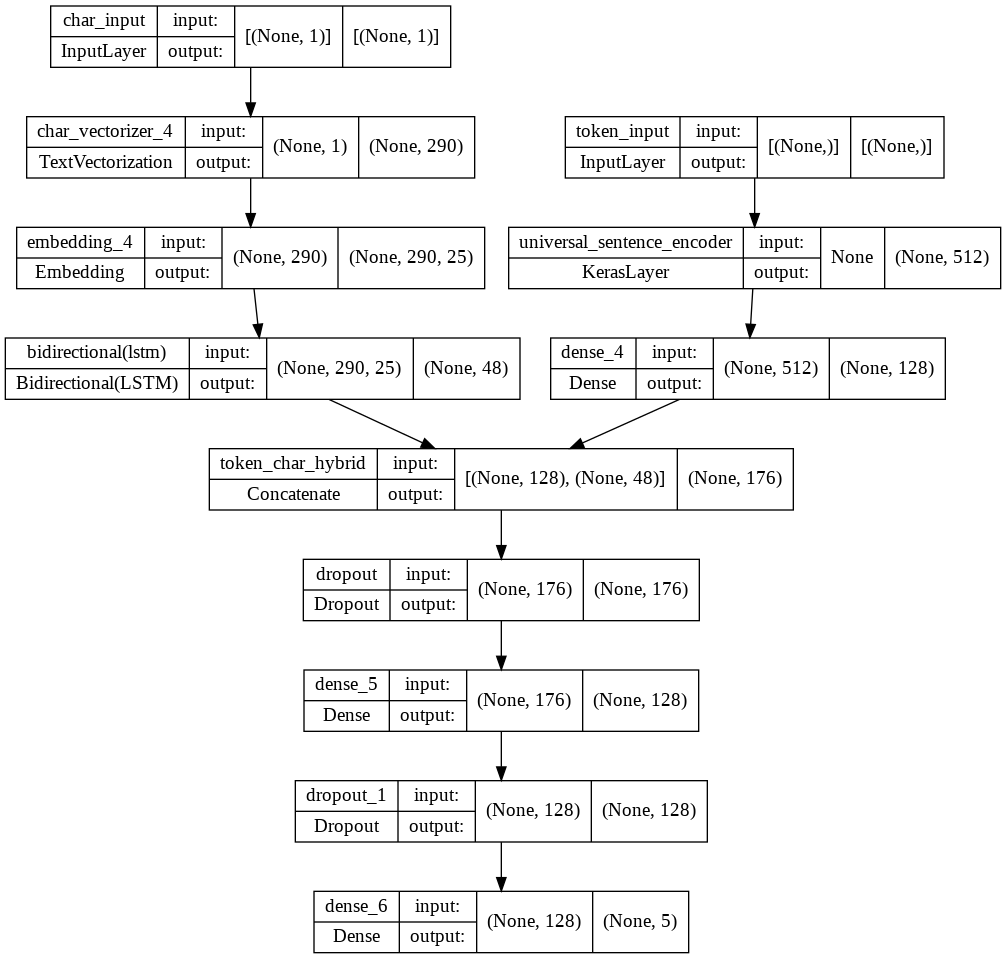

In [ ]:
# Plot hybrid token and character model
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine token and chars into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training and validation token and char embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting a model and token and character=level sequences

In [ ]:
model_4_history = model_4.fit(train_token_char_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 51ms/step - loss: 0.9842 - accuracy: 0.6096 - val_loss: 0.7819 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.8059 - accuracy: 0.6883 - val_loss: 0.7250 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.7832 - accuracy: 0.7020 - val_loss: 0.6966 - val_accuracy: 0.7317


In [ ]:
# Evaluate the model
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.6991 - accuracy: 0.7344


[0.6991020441055298, 0.7344101667404175]

In [ ]:
# Make predictions and calculate results
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.44101681451079,
 'f1': 0.7323709547915052,
 'precision': 0.7330110366290221,
 'recall': 0.734410168145108}

### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

#### Creating positional embeddings

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

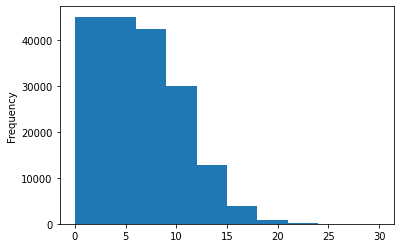

In [ ]:
# Check the distribution of line_number column
train_df.line_number.plot.hist();

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of the line_number column
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:14], train_line_number_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature.

In [ ]:
# How many total lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

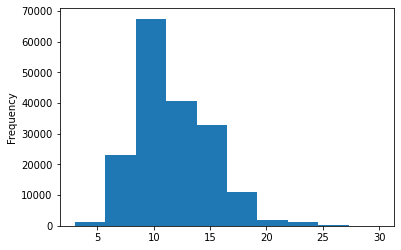

In [ ]:
# Check the distribution
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a total_lines values of 20
np.percentile(train_df["total_lines"], 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of the total_lines feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building a tribrid embedding model

1. Create a token-level model
2. Create a charcater-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4, 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model` 

In [ ]:
model_5_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorizer_5")
model_5_char_vectorizer.adapt(train_chars)
model_5_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="char_embedding_5")

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = model_5_char_vectorizer(char_inputs)
char_embeddings = model_5_char_embedding(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [ ]:
# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [ ]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="positional_token_char_tribrid_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input], # the order is important
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
# Get a summary of the model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer_5 (TextVectori  (None, 290)         0           ['char_inputs[0][0]']            
 zation)                                                                                          
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

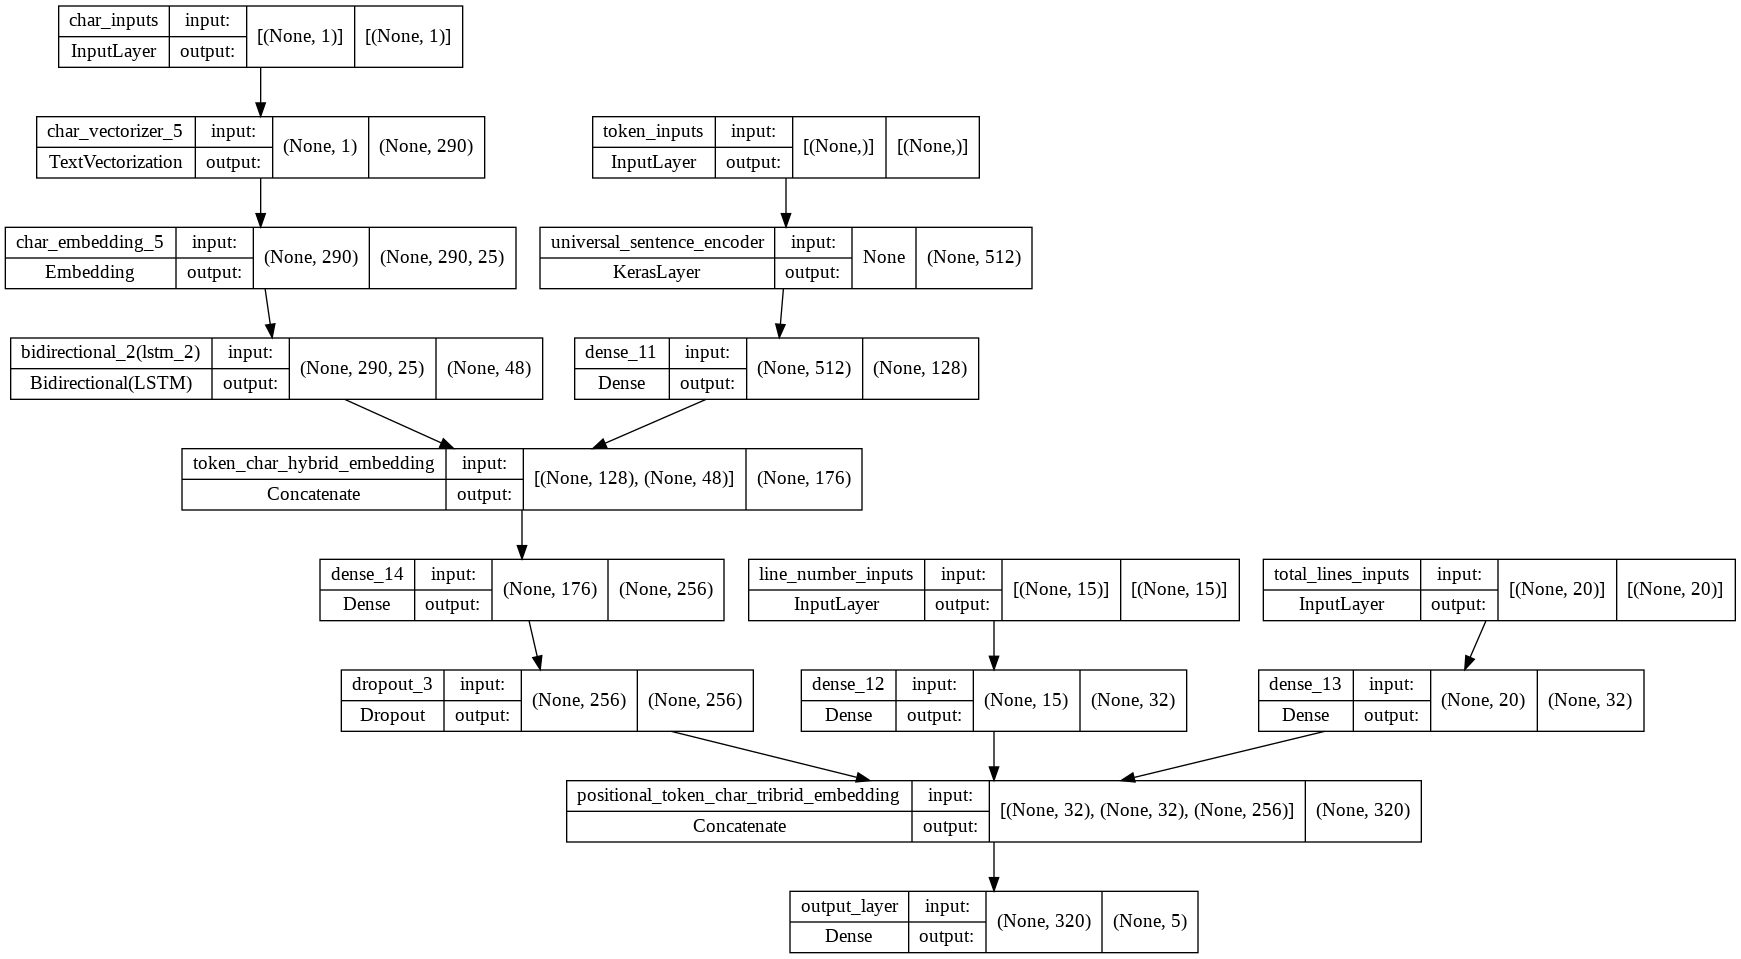

In [ ]:
# Plot tribrid model_5 to explore it visually
tf.keras.utils.plot_model(model_5, show_shapes=True)

**What is label smoothing?**

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class not consider other classes (tunnel vision).

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred probs to other classes, in turn, hopefully improving generalisation: `[0.01, 0.01, 0.96, 0.01, 0.01]`

For more on label smoothing, see this blog post from PyImageSearch: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile positional, token, char embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # label_smoothing helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#### Creating tribid embedding datasets using tf.data

In [ ]:
# Create training and validation datasets with all 4 kinds of input data
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                         train_total_lines_one_hot,
                                                         train_sentences,
                                                         train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                       val_total_lines_one_hot,
                                                       val_sentences,
                                                       val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_tribrid_dataset, val_tribrid_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

#### Fitting, evaluate and making predictions with our tribrid model

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 1.0912 - accuracy: 0.7280 - val_loss: 0.9816 - val_accuracy: 0.8092
Epoch 2/3
562/562 [==============================] - 46s 82ms/step - loss: 0.9692 - accuracy: 0.8126 - val_loss: 0.9531 - val_accuracy: 0.8208
Epoch 3/3
562/562 [==============================] - 41s 73ms/step - loss: 0.9517 - accuracy: 0.8206 - val_loss: 0.9422 - val_accuracy: 0.8275


In [ ]:
# Evaluate the model
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 29s 31ms/step - loss: 0.9392 - accuracy: 0.8300


[0.9391727447509766, 0.8299682140350342]

In [ ]:
# Make predictions and calculate results
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 82.99682245465378,
 'f1': 0.8291088377071516,
 'precision': 0.8288712110915801,
 'recall': 0.8299682245465378}

### Model 6: Custom token embeddings + character embeddings + positional embeddings

#### Building a tribrid custom embedding model

In [ ]:
# Create text vectorization and embedding layers for tokens
model_6_token_vectorizer = TextVectorization(max_tokens=max_tokens,
                                             output_sequence_length=output_seq_len,
                                             name="token_vectorizer_6")
model_6_token_vectorizer.adapt(train_sentences)
model_6_token_embedding = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                           output_dim=128,
                                           mask_zero=True,
                                           input_length=output_seq_len,
                                           name="token_embedding_6")

In [ ]:
# Create text vectorization and embedding layers for characters
model_6_char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                            output_sequence_length=output_seq_char_len,
                                            name="char_vectorization_6")
model_6_char_vectorizer.adapt(train_chars)
model_6_char_embedding = layers.Embedding(input_dim=len(char_vocab),
                                          output_dim=25,
                                          mask_zero=True,
                                          name="char_embedding_6")

In [ ]:
# Token inputs
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_inputs")
token_vectorizer = model_6_token_vectorizer(token_inputs)
token_embeddings = model_6_token_embedding(token_vectorizer)
token_flatten = layers.Flatten()(token_embeddings)
token_outputs = layers.Dense(128, activation="relu")(token_flatten)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectorizer = model_6_char_vectorizer(char_inputs)
char_embeddings = model_6_char_embedding(char_vectorizer)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

In [ ]:
# Combine the models
custom_combined_embeddings = layers.Concatenate(name="custom_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(custom_combined_embeddings)
z = layers.Dropout(0.5)(z)

custom_tribrid_embeddings = layers.Concatenate(name="custom_tribrid_embedding")([line_number_model.output, total_lines_model.output, z])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(custom_tribrid_embeddings)
model_6 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_6_custom_tribrid_embedding_model")

In [ ]:
# Get a summary of the model
model_6.summary()

Model: "model_6_custom_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 token_vectorizer_6 (TextVector  (None, 55)          0           ['token_inputs[0][0]']           
 ization)                                                                                         
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_embedding_6 (Embedding)  (None, 55, 128)      8299648 

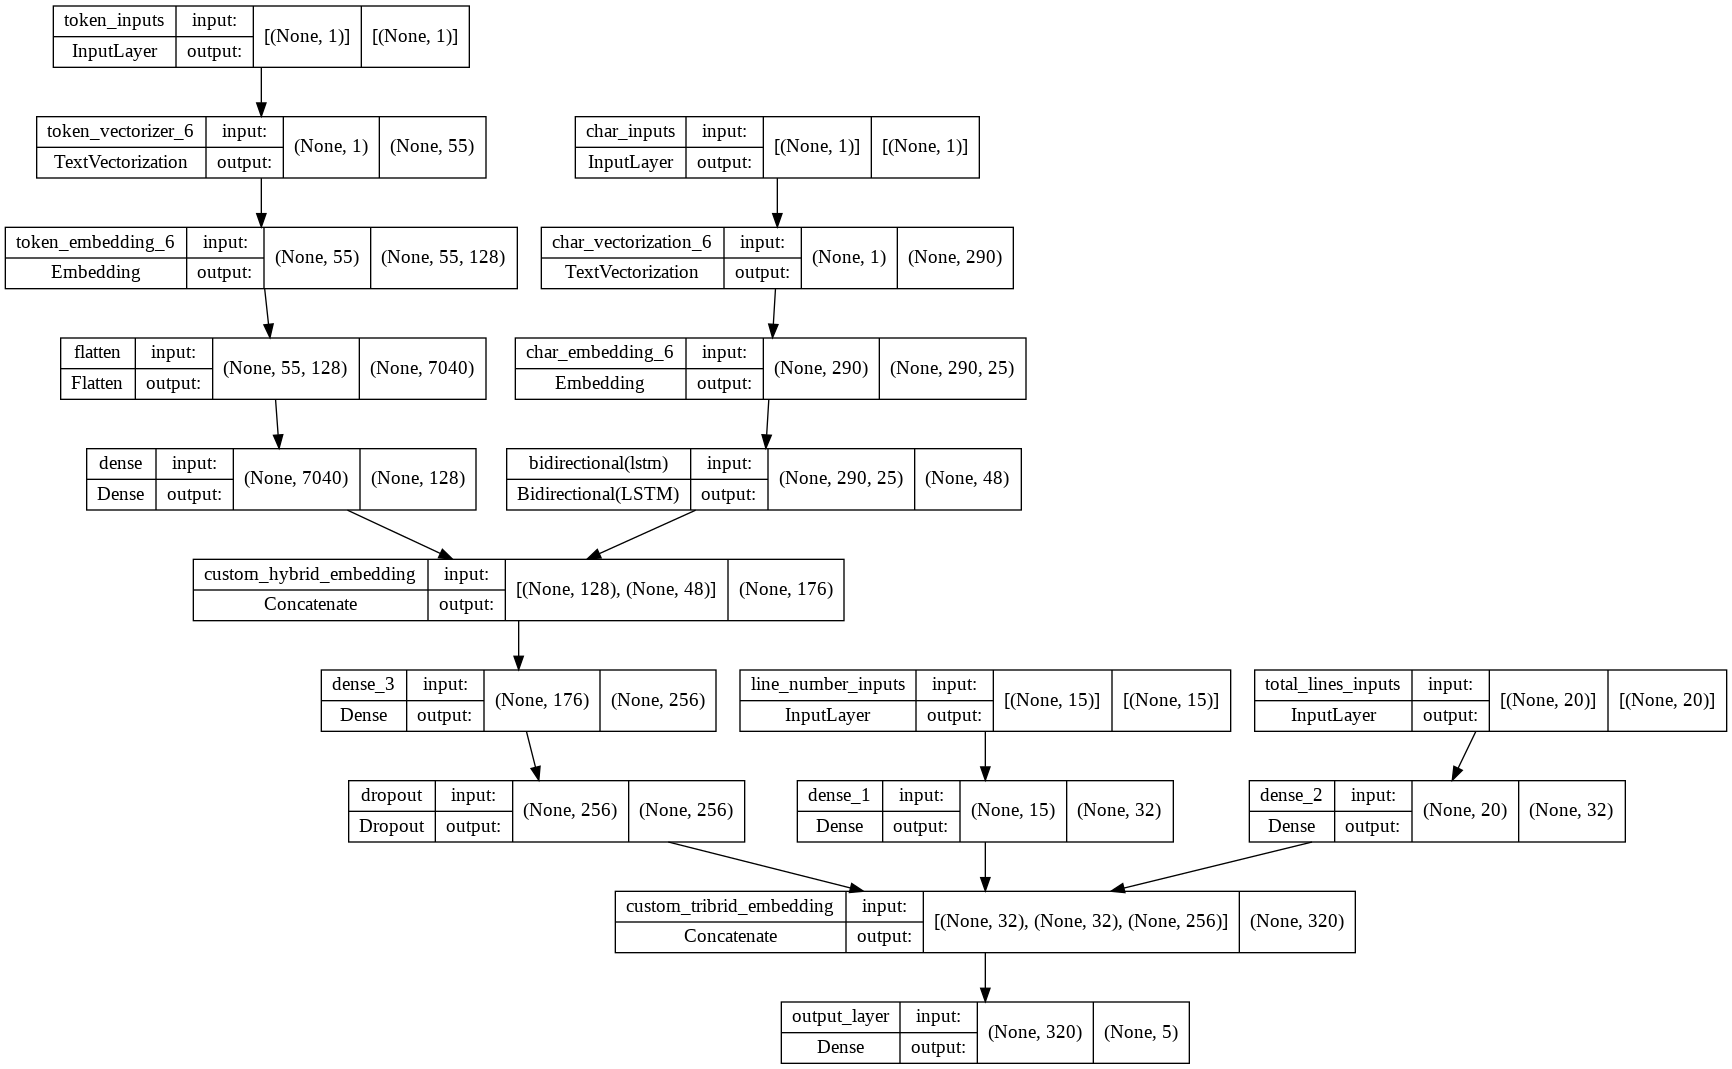

In [ ]:
# Plot model_6
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [ ]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_6_history = model_6.fit(train_tribrid_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 45ms/step - loss: 1.0957 - accuracy: 0.7179 - val_loss: 0.9383 - val_accuracy: 0.8331
Epoch 2/3
562/562 [==============================] - 23s 40ms/step - loss: 0.9395 - accuracy: 0.8329 - val_loss: 0.9150 - val_accuracy: 0.8404
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9159 - accuracy: 0.8471 - val_loss: 0.9072 - val_accuracy: 0.8531


In [ ]:
# Evaluate the model
model_6.evaluate(val_tribrid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.9032 - accuracy: 0.8531


[0.9032449722290039, 0.8530716300010681]

In [ ]:
# Make predictions
model_6_pred_probs = model_6.predict(val_tribrid_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

In [ ]:
# Calculate results
model_6_results = calculate_results(val_labels_encoded, model_6_preds)
model_6_results

{'accuracy': 85.30716271680127,
 'f1': 0.851771011391363,
 'precision': 0.8520247097512784,
 'recall': 0.8530716271680127}

### Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_char_embedding": model_3_results,
                                  "model_4_hybrid_token_char_embedding": model_4_results,
                                  "model_5_tribrid_pos_token_char_embedding": model_5_results,
                                  "model_6_custom_tribrid_post_token_char_embedding": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.498610,0.781443,0.784986,0.782245
model_2_pretrained_token_embedding,71.580829,0.716588,0.715808,0.712831
model_3_char_embedding,65.533563,0.650730,0.655336,0.645572
model_4_hybrid_token_char_embedding,73.441017,0.733011,0.734410,0.732371
model_5_tribrid_pos_token_char_embedding,82.996822,0.828871,0.829968,0.829109
model_6_custom_tribrid_post_token_char_embedding,85.366742,0.852510,0.853667,0.852910


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

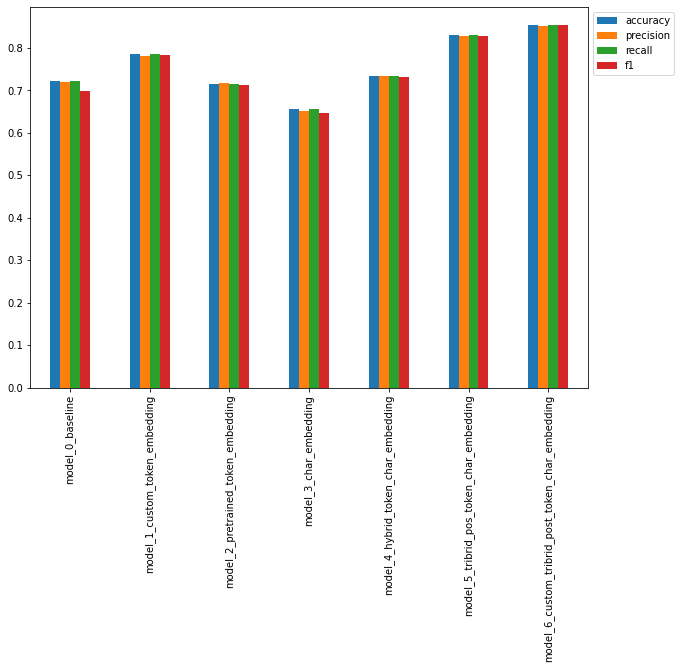

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

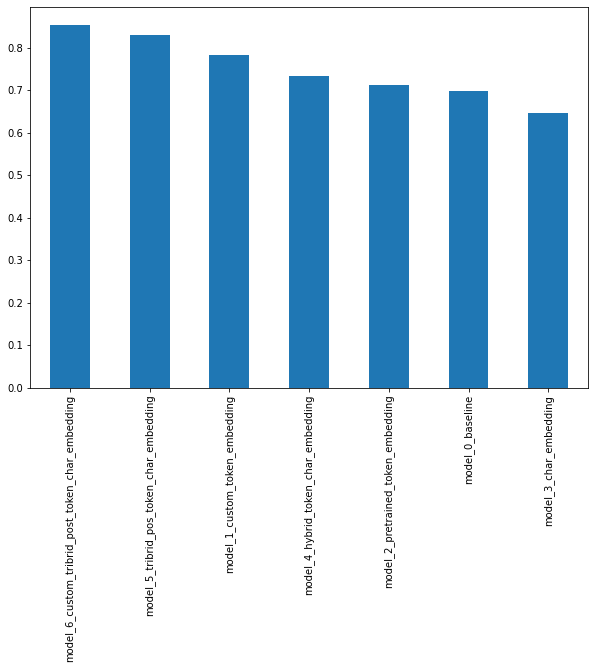

In [ ]:
# Sort models results by f1-scores
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Save and load model

In [ ]:
# Save the best performing model to SavedModel format (default)
model_6.save("/content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model/assets


In [ ]:
# Load in the best performing model
loaded_model_6 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/skimlit_custom_tribrid_model")

In [ ]:
# Make predictions on the loaded model
loaded_model_6_pred_probs = loaded_model_6.predict(val_tribrid_dataset)
loaded_model_6_preds = tf.argmax(loaded_model_6_pred_probs, axis=1)

In [ ]:
# Calculate results of the loaded model
loaded_model_6_results = calculate_results(val_labels_encoded, loaded_model_6_preds)
loaded_model_6_results 

{'accuracy': 85.36674169204291,
 'f1': 0.8529097036488753,
 'precision': 0.8525096434866701,
 'recall': 0.853667416920429}

In [ ]:
# Check if loaded model results is the same as the original model
model_6_results == loaded_model_6_results

True

### Creating test data samples making predictions on them using `model_6`

In [ ]:
# Create testing datasets with all 4 kinds of input data
test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                         test_total_lines_one_hot,
                                                         test_sentences,
                                                         test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Evaluate on the test dataset
model_6.evaluate(test_tribrid_dataset)

942/942 [==============================] - 14s 15ms/step - loss: 0.9100 - accuracy: 0.8503


[0.9099909067153931, 0.8503401279449463]

In [ ]:
# Make predictions on the test dataset
model_6_test_pred_probs = model_6.predict(test_tribrid_dataset)
model_6_test_preds = tf.argmax(model_6_test_pred_probs, axis=1)

In [ ]:
# Calculate results of predictions
model_6_test_results = calculate_results(test_labels_encoded, model_6_test_preds)
model_6_test_results

{'accuracy': 85.03401360544217,
 'f1': 0.8494105710096307,
 'precision': 0.8488725341401056,
 'recall': 0.8503401360544217}

### Finding the most wrong predictions

In [ ]:
predictions = pd.DataFrame({"line_number": test_df["line_number"],
                               "text": test_sentences,
                               "target": test_df["target"],
                               "pred": [class_names[i] for i in model_6_test_preds],
                               "pred_probs": model_6_test_pred_probs.max(axis=1)})
predictions[:20]

,line_number,text,target,pred,pred_probs
0,0,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE,0.456480
1,1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.605311
2,2,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,0.700840
3,3,survival analyses were used to assess the asso...,RESULTS,METHODS,0.660932
4,4,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,0.793127
5,5,when mean hemodynamic profiles were compared i...,RESULTS,RESULTS,0.909123
6,6,multivariable analyses revealed that patients ...,RESULTS,RESULTS,0.908106
7,7,abnormal lfts are common in the adhf populatio...,CONCLUSIONS,CONCLUSIONS,0.720814
8,8,elevated meld-xi scores are associated with po...,CONCLUSIONS,CONCLUSIONS,0.737157
9,0,minimally invasive endovascular aneurysm repai...,BACKGROUND,BACKGROUND,0.522959


In [ ]:
# Find the predictions that are most wrong
predictions["pred_correct"] = predictions["target"] == predictions["pred"]
predictions[:20]

,line_number,text,target,pred,pred_probs,pred_correct
0,0,this study analyzed liver function abnormaliti...,BACKGROUND,OBJECTIVE,0.456480,False
1,1,a post hoc analysis was conducted with the use...,RESULTS,METHODS,0.605311,False
2,2,liver function tests ( lfts ) were measured at...,RESULTS,METHODS,0.700840,False
3,3,survival analyses were used to assess the asso...,RESULTS,METHODS,0.660932,False
4,4,the percentage of patients with abnormal lfts ...,RESULTS,RESULTS,0.793127,True
5,5,when mean hemodynamic profiles were compared i...,RESULTS,RESULTS,0.909123,True
6,6,multivariable analyses revealed that patients ...,RESULTS,RESULTS,0.908106,True
7,7,abnormal lfts are common in the adhf populatio...,CONCLUSIONS,CONCLUSIONS,0.720814,True
8,8,elevated meld-xi scores are associated with po...,CONCLUSIONS,CONCLUSIONS,0.737157,True
9,0,minimally invasive endovascular aneurysm repai...,BACKGROUND,BACKGROUND,0.522959,True


In [ ]:
# Sort the DataFrame to have the most wrong predictions on top
top_100_wrong = predictions[predictions["pred_correct"] == False].sort_values("pred_probs", ascending=False)[:100]
top_100_wrong.head(20)

,line_number,text,target,pred,pred_probs,pred_correct
1976,0,to determine whether the health partner progra...,BACKGROUND,OBJECTIVE,0.950629,False
671,0,to determine whether the insulin resistance th...,METHODS,OBJECTIVE,0.937722,False
14108,15,unique identifier : nct@ .,CONCLUSIONS,BACKGROUND,0.929827,False
21186,8,mean distraction rates were similar between gr...,METHODS,RESULTS,0.921843,False
26058,0,to compare the efficacy of the newcastle infan...,BACKGROUND,OBJECTIVE,0.917528,False
11133,0,to compare the safety and efficacy of dexmedet...,BACKGROUND,OBJECTIVE,0.917018,False
25664,6,rifampicin significantly increased the mean ar...,CONCLUSIONS,RESULTS,0.916908,False
16634,0,to investigate whether remote ischemic conditi...,BACKGROUND,OBJECTIVE,0.915065,False
16347,0,to evaluate the effects of the lactic acid bac...,BACKGROUND,OBJECTIVE,0.907361,False
29170,9,the mean number of intravitreal injections was...,CONCLUSIONS,RESULTS,0.906088,False


### Make example predictions

In [ ]:
# Download example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2022-05-14 14:47:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-05-14 14:47:56 (85.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [ ]:
# Open the example abstracts
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

In [ ]:
# See what the example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


To format the example abstracts into the same structure as the data our model has been trained on, we will have to:

1. Split it into sentences (lines)
2. Split it into characters
3. Find the number of each line
4. Find the total number of lines

While we could use Python's `split()` string method, a more advanced option would be to leverage spaCy's `sentencizer` class.

In [ ]:
# Download spaCy
from spacy.lang.en import English
nlp = English() # setup English sentence parser
sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[0]["abstract"]) # create doc of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 7},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 7},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 7},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 7},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 7},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 7},
 {'line_

In [ ]:
# One-hot encode the line number and total lines
test_abstract_line_number = [line["line_number"] for line in sample_lines]
test_abstract_line_number_one_hot = tf.one_hot(test_abstract_line_number, depth=15)

test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

test_abstract_line_number_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Split lines into characters
def split_chars(text):
  return " ".join(list(text))

abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
# Make predictions
test_abstract_pred_probs = model_6.predict(x=(test_abstract_line_number_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(abstract_lines),
                                              tf.constant(abstract_chars)))
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [class_names[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
# Visualise predictions
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line} (prediction probability: {test_abstract_pred_probs.max(axis=1)[i]:.2f})")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs. (prediction probability: 0.61)
METHODS: Participants were randomly assigned to treatment or wait-list conditions. (prediction probability: 0.66)
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. (prediction probability: 0.68)
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition. (prediction probability: 0.66)
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). (prediction probability: 0.66)
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. (prediction probability: 0.64)
RESULTS: High levels of parent, child and staff satisfaction were reported, along with hig

#### Create a function to do the above

In [ ]:
from spacy.lang.en import English

def make_example_predictions(example_abstracts, model, class_names=class_names):
  
  # See what the example abstracts look like
  abstracts = pd.DataFrame(example_abstracts)
  
  for i in range(len(abstracts)):
    nlp = English() # setup English sentence parser
    sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
    nlp.add_pipe(sentencizer) # add sentence splitting pipeline object to sentence parser
    doc = nlp(example_abstracts[i]["abstract"]) # create doc of parsed sequences, change index for a different abstract
    abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type

    # Get total number of lines
    total_lines_in_sample = len(abstract_lines)

    # Go through each line in abstract and create a list of dictionaries containing features for each line
    sample_lines = []
    for line_idx, line in enumerate(abstract_lines):
      sample_dict = {}
      sample_dict["text"] = str(line)
      sample_dict["line_number"] = line_idx
      sample_dict["total_lines"] = total_lines_in_sample - 1
      sample_lines.append(sample_dict)

    # One-hot encode the line number and total lines
    test_abstract_line_number = [line["line_number"] for line in sample_lines]
    test_abstract_line_number_one_hot = tf.one_hot(test_abstract_line_number, depth=15)

    test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
    test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)

    abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

    # Make predictions
    test_abstract_pred_probs = model.predict(x=(test_abstract_line_number_one_hot,
                                                  test_abstract_total_lines_one_hot,
                                                  tf.constant(abstract_lines),
                                                  tf.constant(abstract_chars)))
    test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
    test_abstract_pred_classes = [class_names[i] for i in test_abstract_preds]

    # Visualise predictions
    for j, line in enumerate(abstract_lines):
      print(f"{test_abstract_pred_classes[j]}: {line} (prediction probability: {test_abstract_pred_probs.max(axis=1)[j]:.2f})")
    
    print("\n")

# Split lines into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Open the example abstracts
import json
with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

make_example_predictions(example_abstracts, model_6)

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs. (prediction probability: 0.61)
METHODS: Participants were randomly assigned to treatment or wait-list conditions. (prediction probability: 0.66)
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. (prediction probability: 0.68)
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition. (prediction probability: 0.66)
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). (prediction probability: 0.66)
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. (prediction probability: 0.64)
RESULTS: High levels of parent, child and staff satisfaction were reported, along with hig

## Using 100% of the data

Train `model_6` on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, we'll use:

* `tf.keras.callbacks.ModelCheckpoint` to save the model's best weights only
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once validation loss has stopped improving for ~3 epochs

In [1]:
# Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8c93ec2f-6615-1aac-8726-faea33c854e2)


### Get data and preprocess it

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Download helper functions
!wget https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py

--2022-05-15 12:43:58--  https://raw.githubusercontent.com/cherylktt/tensorflow/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16898 (17K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  16.50K  --.-KB/s    in 0.001s  

2022-05-15 12:43:58 (11.2 MB/s) - ‘helper_functions.py’ saved [16898/16898]



In [17]:
!unzip "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip" -d "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign"

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [2]:
from helper_functions import get_lines
from helper_functions import preprocess_text_with_line_numbers

In [3]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Get data from file and preprocess it
train_all_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_all_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_all_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

train_all_samples[:20]

[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'total_lines': 10},
 {'line_number': 1,
  'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'total_lines': 10},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'total_lines': 10},
 {'line_number': 3,
  'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'total_lines': 10},
 {'line_number': 4,
  'tar

In [5]:
# Turn data into a DataFrame
import pandas as pd
train_all_df = pd.DataFrame(train_all_samples)
val_all_df = pd.DataFrame(val_all_samples)
test_all_df = pd.DataFrame(test_all_samples)

train_all_df.head(20)

,line_number,target,text,total_lines
0,0,BACKGROUND,the emergence of hiv as a chronic condition me...,10
1,1,BACKGROUND,this paper describes the design and evaluation...,10
2,2,METHODS,this study is designed as a randomised control...,10
3,3,METHODS,the intervention group will participate in the...,10
4,4,METHODS,the program is based on self-efficacy theory a...,10
5,5,METHODS,participants will access the program for a min...,10
6,6,METHODS,primary outcomes are domain specific self-effi...,10
7,7,METHODS,"secondary outcomes include : depression , anxi...",10
8,8,METHODS,"data collection will take place at baseline , ...",10
9,9,CONCLUSIONS,results of the positive outlook study will pro...,10


#### Get lists of sentences

In [6]:
# Convert abstract text lines into lists
train_all_sentences = train_all_df["text"].to_list()
val_all_sentences = val_all_df["text"].to_list()
test_all_sentences = test_all_df["text"].to_list()

len(train_all_sentences), len(val_all_sentences), len(test_all_sentences)

(2211861, 28932, 29493)

In [7]:
# View the first 20 training sentences
train_all_sentences[:20]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

### Make numeric labels

In [8]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_all_labels_one_hot = one_hot_encoder.fit_transform(train_all_df["target"].to_numpy().reshape(-1, 1))
val_all_labels_one_hot = one_hot_encoder.transform(val_all_df["target"].to_numpy().reshape(-1, 1))
test_all_labels_one_hot = one_hot_encoder.transform(test_all_df["target"].to_numpy().reshape(-1, 1))

# Check the labels
train_all_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

#### Label encode labels

In [9]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_all_labels_encoded = label_encoder.fit_transform(train_all_df["target"].to_numpy())
val_all_labels_encoded = label_encoder.transform(val_all_df["target"].to_numpy())
test_all_labels_encoded = label_encoder.transform(test_all_df["target"].to_numpy())

# Check the labels
train_all_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [10]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Preparing data for deep sequence models

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
# Find average numbe of tokens in the training sentences
sent_all_lens = [len(sentence.split()) for sentence in train_all_sentences]
avg_sent_all_lens = np.mean(sent_all_lens)
avg_sent_all_lens

26.229355280462922

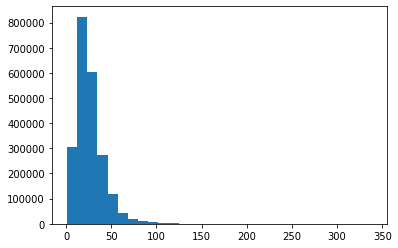

In [13]:
# Check distribution
import matplotlib.pyplot as plt
plt.hist(sent_all_lens, bins=30);

In [14]:
# Check for 95th percentile
output_all_seq_len = int(np.percentile(sent_all_lens, 95))
output_all_seq_len

54

### Creating token-level vectorizer

In [15]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 331000 # based on table 2 in https://arxiv.org/pdf/1710.06071
token_vectorizer_all_data = TextVectorization(max_tokens=max_tokens,
                                             output_sequence_length=output_all_seq_len,
                                             name="token_vectorizer_all_data")

In [16]:
# Adapt text vectorizer to 50% of training data (training on more than 50% causes Google Colab to crash)
import random
train_all_sentences_50_percent = random.choices(train_all_sentences, k=int(0.5*len(train_all_sentences)))
token_vectorizer_all_data.adapt(train_all_sentences_50_percent)

KeyboardInterrupt: ignored

In [ ]:
# Find number of words in training vocabulary
rct_200k_text_vocab = token_vectorizer_all_data.get_vocabulary()
len(rct_200k_text_vocab)

### Creating custom token-level embedding

In [18]:
token_embedding_all_data = layers.Embedding(input_dim=len(rct_200k_text_vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name="token_embedding_all_data",
                                            input_length=output_all_seq_len)

NameError: ignored

### Creating character-level vectorizer

In [19]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [20]:
# Split sequence level data splits into character level data splits
train_all_chars = [split_chars(sentence) for sentence in train_all_sentences]
val_all_chars = [split_chars(sentence) for sentence in val_all_sentences]
test_all_chars = [split_chars(sentence) for sentence in test_all_sentences]

In [21]:
# Find average character length
char_all_len = [len(sentence) for sentence in train_all_sentences]
mean_char_all_len = np.mean(char_all_len)
mean_char_all_len

147.82646377869133

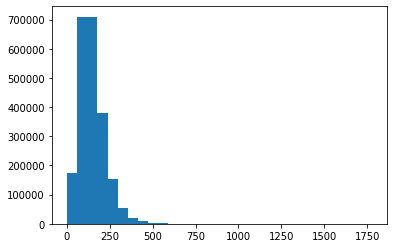

In [22]:
# Check distribution of sequences at a character level
plt.hist(char_all_len, bins=30);

In [23]:
# Check for 95th percentile
output_all_seq_char_len = int(np.percentile(char_all_len, 95))
output_all_seq_char_len

284

In [24]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [25]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer_all_data = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                             output_sequence_length=output_all_seq_char_len,
                                             name="char_vectorizer_all_data")

In [ ]:
# Adapt character vectorizer to 50% of training data (training on more than 50% causes Google Colab to crash)
import random
train_all_chars_50_percent = random.choices(train_all_chars, k=int(0.5*len(train_all_chars)))
char_vectorizer_all_data.adapt(train_all_chars)

In [ ]:
# Check character vocabulary
char_all_vocab = char_vectorizer_all_data.get_vocabulary()

### Creating character-level embedding

In [ ]:
char_embedding_all_data = layers.Embedding(input_dim=len(char_all_vocab),
                                           output_dim=25,
                                           mask_zero=True,
                                           name="char_embedding_all_data")

### Creating positional embeddings

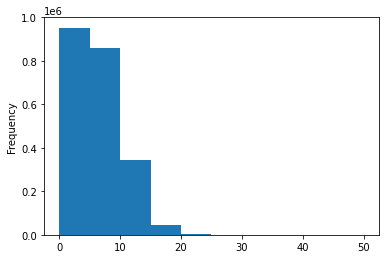

In [26]:
# Check the distribution of line_number column
train_all_df.line_number.plot.hist();

In [35]:
# Use TensorFlow to create one-hot encoded tensors of the line_number feature
train_all_line_number_one_hot = tf.one_hot(train_all_df["line_number"].to_numpy(), depth=15)
val_all_line_number_one_hot = tf.one_hot(val_all_df["line_number"].to_numpy(), depth=15)
test_all_line_number_one_hot = tf.one_hot(test_all_df["line_number"].to_numpy(), depth=15)

train_all_line_number_one_hot[:10]

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

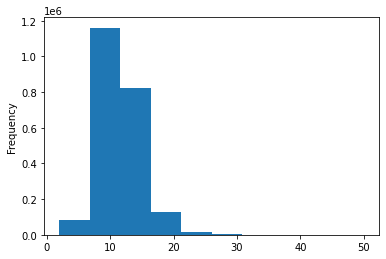

In [29]:
# Check the distribution of total lines column
train_all_df.total_lines.plot.hist();

In [34]:
# Use TensorFlow to create one-hot encoded tensors of the total_lines feature
train_all_total_lines_one_hot = tf.one_hot(train_all_df["total_lines"].to_numpy(), depth=20)
val_all_total_lines_one_hot = tf.one_hot(val_all_df["total_lines"].to_numpy(), depth=20)
test_all_total_lines_one_hot = tf.one_hot(test_all_df["total_lines"].to_numpy(), depth=20)

train_all_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
     

### Creating tribrid embedding datasets using tf.data

In [36]:
# Create training, validation and test datasets with all 4 kinds of input data
train_tribrid_all_data = tf.data.Dataset.from_tensor_slices((train_all_line_number_one_hot,
                                                             train_all_total_lines_one_hot,
                                                             train_all_sentences,
                                                             train_all_chars))
train_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(train_all_labels_one_hot)
train_tribrid_all_dataset = tf.data.Dataset.zip((train_tribrid_all_data, train_tribrid_all_labels))
train_tribrid_all_dataset = train_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_all_data = tf.data.Dataset.from_tensor_slices((val_all_line_number_one_hot,
                                                             val_all_total_lines_one_hot,
                                                             val_all_sentences,
                                                             val_all_chars))
val_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(val_all_labels_one_hot)
val_tribrid_all_dataset = tf.data.Dataset.zip((val_tribrid_all_data, val_tribrid_all_labels))
val_tribrid_all_dataset = val_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_all_data = tf.data.Dataset.from_tensor_slices((test_all_line_number_one_hot,
                                                             test_all_total_lines_one_hot,
                                                             test_all_sentences,
                                                             test_all_chars))
test_tribrid_all_labels = tf.data.Dataset.from_tensor_slices(test_all_labels_one_hot)
test_tribrid_all_dataset = tf.data.Dataset.zip((test_tribrid_all_data, test_tribrid_all_labels))
test_tribrid_all_dataset = test_tribrid_all_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Building a custom tribrid embedding model